In [1]:
# import libraries
import pandas as pd
import spacy
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tomotopy as tp
import re

/opt/anaconda3/envs/newfiat/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# import data
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [3]:
print(sum(train['helpfulness_cat'])/len(train))


0.7637377963737796


In [4]:
document_lengths = np.array(list(map(len, train['imdb_user_review'].str.split(' '))))

print("The average number of words in a document is: {}.".format(np.mean(document_lengths)))
print("The minimum number of words in a document is: {}.".format(min(document_lengths)))
print("The maximum number of words in a document is: {}.".format(max(document_lengths)))

The average number of words in a document is: 175.48888888888888.
The minimum number of words in a document is: 6.
The maximum number of words in a document is: 3954.


/opt/anaconda3/envs/newfiat/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:title={'center':'Distribution of number of words'}, xlabel='Number of words', ylabel='Density'>

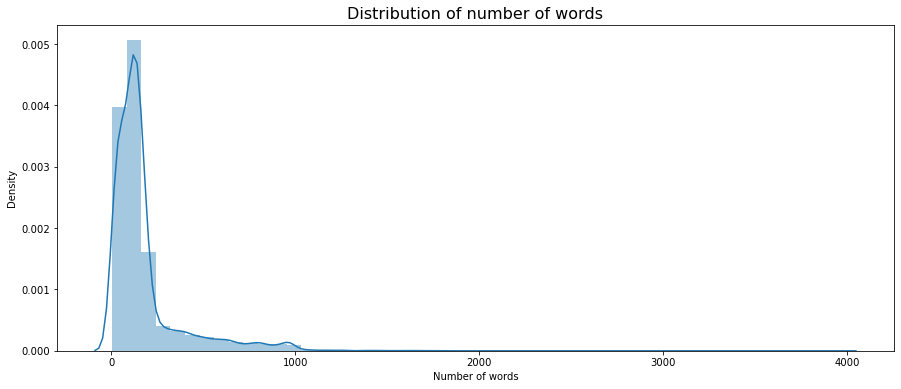

In [5]:
fig, ax = plt.subplots(figsize=(15,6))

ax.set_title("Distribution of number of words", fontsize=16)
ax.set_xlabel("Number of words")
sns.distplot(document_lengths, bins=50, ax=ax)

In [6]:
print("There are {} documents with over 1500 words.".format(sum(document_lengths > 1500)))
print("There are {} documents with max 6 words.".format(sum(document_lengths <= 6)))

There are 9 documents with over 1500 words.
There are 2 documents with max 6 words.


### Basic Data Cleansing

In [7]:
# data sample
train['imdb_user_review'][0]

'It is hard to find such delightful and adorable movies these days as \\"The Kid\\". It is a silent movie but so rich, winning and beautiful that you don\\u00b4t nead words. Chaplin and 6-year old Coogan are possibly the most charming pair I have ever seen in my life. The film succees to be nicely light and full of joy but also overwhelmingly sad and sentimental. I always get my eyes full with tears of saddness and happiness. And I really never cry in movies. And the music...its simply Oscar-level! The movie is sympathetic, full of feeling, touchingly funny moments. It is truly a masterpiece showing how extraordinary talented person Charlie Chaplin was considering this film is respectively over 80 years old! So don\\u00b4t you miss it because of it\\u00b4s age, don\\u00b4t miss it.'

In [8]:
def basic_clean(text):
    """
    Remove \\,\n,\t,... from text
    Remove whitespace from text
    change to lowercase
    """
    
    # Replacing all the occurrences of \n,\\n,\t,\\ with a space.
    Formatted_text = text.replace('\\n', ' ').replace('\n', ' ').replace('\t',' ').replace('\'', ' ').replace('"',' ')
    pattern = re.compile(r'\s+')
    Formatted_text = Formatted_text.lower()
    Formatted_text = Formatted_text.replace('\\u00b4',' ').replace('\\',' ')
    Without_whitespace = re.sub(pattern, ' ', Formatted_text)
    Formatted_text = Without_whitespace.replace('?', ' ? ').replace(')', ') ')
    return Formatted_text

In [9]:
# cleaning data
train['imdb_user_review'] = train['imdb_user_review'].apply(basic_clean)

In [10]:
train['imdb_user_review'][0]

'it is hard to find such delightful and adorable movies these days as the kid . it is a silent movie but so rich, winning and beautiful that you don t nead words. chaplin and 6-year old coogan are possibly the most charming pair i have ever seen in my life. the film succees to be nicely light and full of joy but also overwhelmingly sad and sentimental. i always get my eyes full with tears of saddness and happiness. and i really never cry in movies. and the music...its simply oscar-level! the movie is sympathetic, full of feeling, touchingly funny moments. it is truly a masterpiece showing how extraordinary talented person charlie chaplin was considering this film is respectively over 80 years old! so don t you miss it because of it s age, don t miss it.'

### BoW

In [35]:
from sklearn.utils import shuffle
import os
import nlpaug.augmenter.word as naw
import wget
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/yilingng/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [21]:
train_bow = train.copy()
train_bow.head()

,helpfulness_cat,imdb_user_review
0,1.0,it is hard to find such delightful and adorabl...
1,1.0,"they don t make films like this faded, hauntin..."
2,1.0,i first viewed this movie in 1924 at age 6 yrs...
3,1.0,i doubt that i d ever seen anything resembling...
4,1.0,i was shocked to find myself riveted to this m...


In [36]:
## Further data cleaning for BoW
# step 1: remove stop words 
stop = stopwords.words('english')
train_bow["imdb_user_review"] = list(map(lambda x: ' '.join([word for word in x.split() if word not in stop]),train_bow["imdb_user_review"]))

# step 2: lemmatize the words
lemmatizer = WordNetLemmatizer()
# see = lemmatizer.lemmatize(comments)
train_bow["imdb_user_review"] = list(map(lambda x: ' '.join([lemmatizer.lemmatize(word, pos="v") for word in x.split()]),train_bow["imdb_user_review"]))

In [49]:
# find the maximum number of words in a document 
document_lengths_bow = np.array(list(map(len, train_bow['imdb_user_review'].str.split(' '))))

print("The average number of words in a document is: {}.".format(np.mean(document_lengths_bow)))
print("The minimum number of words in a document is: {}.".format(min(document_lengths_bow)))
print("The maximum number of words in a document is: {}.".format(max(document_lengths_bow)))

The average number of words in a document is: 93.8838679683868.
The minimum number of words in a document is: 4.
The maximum number of words in a document is: 1960.


In [38]:
Train_df, Valid_df = train_test_split(train_bow, test_size=0.2, random_state=42)

In [39]:
# nlp data augmentation
# check the percentage of each label in the data set
Train_df.groupby('helpfulness_cat').count()/len(train)

,imdb_user_review
helpfulness_cat,
0.0,0.189679
1.0,0.610321


In [40]:
# !pip install nlpaug
# !pip install wget
# download model from: https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit?resourcekey=0-wjGZdNAUop6WykTtMip30g
# url = 'https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz'
# filename = wget.download(url)
# gzip -d GoogleNews-vectors-negative300.bin.gz 

current_path = os.getcwd()
# load the google model path
google_model_path = os.path.join(current_path, 'GoogleNews-vectors-negative300.bin')

aug = naw.WordEmbsAug(
    model_type='word2vec', model_path=google_model_path,
    action="insert")

In [41]:
# augmente the unhelpful reviews
unhelpful_reviews = Train_df[Train_df['helpfulness_cat'] == 0].reset_index(drop=True)

def augment_text(df_train,df_unhelpful,num,pr=0.2):
    aug.aug_p=pr
    new_text=[]

    ## data augmentation loop
    for i in tqdm(np.random.randint(0,len(df_unhelpful),num)):
            text = unhelpful_reviews.iloc[i]['imdb_user_review']
            augmented_text = aug.augment(text)
            new_text.append(augmented_text)
    
    
    ## dataframe
    new=pd.DataFrame({'imdb_user_review':new_text,'helpfulness_cat':0})
    new['imdb_user_review'] = new['imdb_user_review'].apply(lambda x: ' '.join(x))
    df_new=shuffle(df_train.append(new).reset_index(drop=True))
    return df_new

In [42]:
Train_df = augment_text(Train_df,unhelpful_reviews,4524)

100%|██████████| 4524/4524 [00:02<00:00, 1948.85it/s]
/var/folders/yr/s6gbqy0s2kd5cn1_s40p4b2w0000gn/T/ipykernel_2828/1872353011.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new=shuffle(df_train.append(new).reset_index(drop=True))


In [43]:
# Train_df has equal helpful/unhelpful
Train_df.groupby('helpfulness_cat').count()

,imdb_user_review
helpfulness_cat,
0.0,6564
1.0,6564


In [44]:
X_train_bow = Train_df.drop(['helpfulness_cat'], axis=1)
y_train_bow = Train_df.loc[:, 'helpfulness_cat']
X_test_bow = Valid_df.drop(['helpfulness_cat'], axis=1)
y_test_bow = Valid_df.loc[:, 'helpfulness_cat']

In [45]:
# load libraries
from collections import Counter, OrderedDict, defaultdict
from typing import Dict, List, Tuple
import numpy as np
from nltk.tokenize import TreebankWordTokenizer
import spacy
import pandas as pd

In [46]:
#!python -m spacy download en_core_web_lg

In [47]:
# initialise a pipeline
nlp = spacy.load("en_core_web_lg")

# Disabling components in the nlp pipeline to speed up pre-processing
nlp.disable_pipes('tagger','attribute_ruler')
print('Pipeline after:', nlp.pipeline)

Pipeline after: [('tok2vec', <spacy.pipeline.tok2vec.Tok2Vec object at 0x7faa0e45b7c0>), ('parser', <spacy.pipeline.dep_parser.DependencyParser object at 0x7faa19966270>), ('lemmatizer', <spacy.lang.en.lemmatizer.EnglishLemmatizer object at 0x7fa8ab4dee00>), ('ner', <spacy.pipeline.ner.EntityRecognizer object at 0x7fa9d053aba0>)]


In [48]:
# Step 1: Tokenize the words in each moview review
docs_tokens_train, docs_tokens_test = [], []
# train set
for item in X_train_bow["imdb_user_review"]:
    tmp_tokens = [
        token.lemma_
        for token in nlp(item)
        if not token.is_stop and not token.is_punct and token.is_alpha
    ]
    docs_tokens_train.append(tmp_tokens)
    del tmp_tokens

# test set
for item in X_test_bow["imdb_user_review"]:
    tmp_tokens = [
        token.lemma_
        for token in nlp(item)
        if not token.is_stop and not token.is_punct and token.is_alpha
    ]
    docs_tokens_test.append(tmp_tokens)
    del tmp_tokens

/opt/anaconda3/envs/newfiat/lib/python3.9/site-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


In [50]:
# Step 2: building a dictionary collection where the keys are tokenized words 
# the larger the number, the lower the word frequency 
# The dictionary key-value pairs are also written to a text file named vocab_file.txt 
# so they can be used later by an NLP system.
def make_vocab(document_tokens,output_file):
    word_freq_dict = {}   # key = word, value = frequency

    for i in range(len(document_tokens)):
        reviews = document_tokens[i]
        for review in reviews:
            if review in word_freq_dict:
                word_freq_dict[review] += 1
            else:
                word_freq_dict[review] = 1

    kv_list = []  # list of word-freq tuples so can sort
    for (k,v) in word_freq_dict.items():
        kv_list.append((k,v))
    
        # list of tuples index is 0-based rank, val is (word,freq)
    sorted_kv_list = \
        sorted(kv_list, key=lambda x: x[1], \
            reverse=True)  # sort by freq

    f = open(output_file, "w", encoding="utf8")
    vocab_dict = {}  
            # key = word, value = 1-based rank 
            # ('the' = 1, 'a' = 2, etc.)
    for i in range(len(sorted_kv_list)):  # filter here . . 
        w = sorted_kv_list[i][0]  # word is at [0]
        vocab_dict[w] = i+1       # 1-based as in Keras dataset
        f.write(w + " " + str(i+1) + "\n")  # save word-space-index
    f.close()

In [51]:
# apply make_vocab function on train and test sets
make_vocab(docs_tokens_train,".\\vocab_file_train.txt")
make_vocab(docs_tokens_test,".\\vocab_file_test.txt")

# read vocab file - train 
vocab_dict_train = {}
with open(".\\vocab_file_train.txt") as f:
    for line in f:
       (key, val) = line.split()
       vocab_dict_train[str(key)] = int(val)

# read vocab file - test
vocab_dict_test = {}
with open(".\\vocab_file_test.txt") as f:
    for line in f:
       (key, val) = line.split()
       vocab_dict_test[str(key)] = int(val)

In [54]:
# Step 3: assigning id to each words/tokens in each review based on vocab_dict
def generate_file(reviews_lists, outpt_file, vocab_dict, max_review_len):

  # write first time, append later.
  fout = open(outpt_file, "w", encoding="utf8")  
  offset = 3  # Keras offset: 'the' = 1 (most frequent) 1+3 = 4
      
  for i in range(len(reviews_lists)):  # walk each review-list
    curr_review = reviews_lists[i]
    n_words = len(curr_review)     
    if n_words > max_review_len: # 1960 is our maximum words in the document
      continue  # next i, continue without writing anything

    n_pad = max_review_len - n_words   # number of 0s to prepend.  

    for j in range(n_pad):
      fout.write("0 ")
    
    for word in curr_review: 
      # a word in test set might not have been in train set     
      if word not in vocab_dict:  
        fout.write("2 ")   # 2 is the special out-of-vocab index        
      else:
        idx = vocab_dict[word] + offset
        fout.write("%d " % idx)
    
    fout.write("\n") 
        
  fout.close()

In [57]:
## apply generate file
# train list
review_list_train = X_train_bow["imdb_user_review"].to_list()
generate_file(review_list_train,".\imdb_id_train.txt",vocab_dict_train,1960)

# test list
review_list_test = X_test_bow["imdb_user_review"].to_list()
generate_file(review_list_test,".\imdb_id_test.txt",vocab_dict_test,1960)

In [58]:
## train
# read file
with open('.\\imdb_id_train.txt') as f:
    id_array_train = f.readlines()

# covert to array
train_list = []
for i in range(len(id_array_train)):
    tmp = np.array(id_array_train[i].split())
    train_list.append(tmp)
id_array_train_new = np.array(train_list,dtype=float)

## test
# read file
with open('.\\imdb_id_test.txt') as f:
    id_array_test = f.readlines()

# covert to array
test_list = []
for i in range(len(id_array_test)):
    tmp = np.array(id_array_test[i].split())
    test_list.append(tmp)
id_array_test_new = np.array(test_list,dtype=float)

Build the model

In [59]:
import numpy as np
import torch as T
device = T.device('cpu')

In [68]:
# LSTM ---------------------------------------
class LSTM_Net(T.nn.Module):
  def __init__(self):
    # vocab_size = 129892
    super(LSTM_Net, self).__init__()
    self.embed = T.nn.Embedding(54460, 32)
    self.lstm = T.nn.LSTM(32, 100)
    self.fc1 = T.nn.Linear(100, 2)  # 0=neg, 1=pos
 
  def forward(self, x):
    # x = review/sentence. length = fixed w/ padding
    z = self.embed(x)  # x can be arbitrary shape - not
    z = z.reshape(1960, -1, 32)  # seq bat embed
    lstm_oupt, (h_n, c_n) = self.lstm(z)
    z = lstm_oupt[-1]  # or use h_n. [1,100]
    z = T.log_softmax(self.fc1(z), dim=1)  # NLLLoss()
    return z 

# IMBD Dataset --------------------------------
class IMDB_Dataset(T.utils.data.Dataset):
  def __init__(self, id_array,y_train):
    self.x_data = T.tensor(id_array, dtype=T.int64) 
    self.y_data = T.tensor(y_train.to_list(), dtype=T.int64) 

  def __len__(self):
    return len(self.x_data)

  def __getitem__(self, idx):
    tokens = self.x_data[idx]
    trgts = self.y_data[idx] 
    return (tokens, trgts)

# accuracy ------------------------------------
def accuracy(model, dataset):
  # data_x and data_y are lists of tensors
  # assumes model.eval()
  num_correct = 0; num_wrong = 0
  ldr = T.utils.data.DataLoader(dataset,
    batch_size=1, shuffle=False)
  for (batch_idx, batch) in enumerate(ldr):
    X = batch[0]  # inputs
    Y = batch[1]  # target sentiment label
    with T.no_grad():
      oupt = model(X)  # log-probs
   
    idx = T.argmax(oupt.data)
    if idx == Y:  # predicted == target
      num_correct += 1
    else:
      num_wrong += 1
  acc = (num_correct * 100.0) / (num_correct + num_wrong)
  return acc

In [69]:
# 1. load data
print("\nLoading preprocessed train and test data ")
train_bow_ds = IMDB_Dataset(id_array_train_new,y_train_bow)
test_bow_ds = IMDB_Dataset(id_array_test_new,y_test_bow)

bat_size = 8
train_ldr = T.utils.data.DataLoader(train_bow_ds, batch_size=bat_size, shuffle=True, drop_last=True)
n_train = len(train_bow_ds)
n_test = len(test_bow_ds)
print("Num train = %d Num test = %d " % (n_train, n_test))


Loading preprocessed train and test data 
Num train = 12398 Num test = 1991 


/var/folders/yr/s6gbqy0s2kd5cn1_s40p4b2w0000gn/T/ipykernel_2828/3369508858.py:23: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  self.y_data = T.tensor(y_train.to_list(), dtype=T.int64)


In [70]:
# 2. create network
net = LSTM_Net().to(device)

In [71]:
# 3. train model
loss_func = T.nn.NLLLoss()  # log-softmax() activation
optimizer = T.optim.Adam(net.parameters(), lr=1.0e-3)
max_epochs = 2
log_interval = 2  # display progress

print("\nbatch size = " + str(bat_size))
print("loss func = " + str(loss_func))
print("optimizer = Adam ")
print("learn rate = 0.001 ")
print("max_epochs = %d " % max_epochs)

print("\nStarting training ")
net.train()  # set training mode
for epoch in range(0, max_epochs):
    tot_err = 0.0  # for one epoch
    for (batch_idx, batch) in enumerate(train_ldr):
      X = T.transpose(batch[0], 0, 1)
      Y = batch[1]
      optimizer.zero_grad()
      oupt = net(X)

      loss_val = loss_func(oupt, Y) 
      tot_err += loss_val.item()
      loss_val.backward()  # compute gradients
      optimizer.step()     # update weights
  
    if epoch % log_interval == 0:
      print("epoch = %4d  |" % epoch, end="")
      print("   loss = %10.4f  |" % tot_err, end="")

      net.eval()
      train_acc = accuracy(net, train_bow_ds)
      print("  accuracy = %8.2f%%" % train_acc)
      net.train()
print("Training complete")


batch size = 8
loss func = NLLLoss()
optimizer = Adam 
learn rate = 0.001 
max_epochs = 2 

Starting training 
epoch =    0  |   loss =  1075.5384  |  accuracy =    51.94%
Training complete


In [72]:
# 4. evaluate model
net.eval()
test_acc = accuracy(net, test_bow_ds)
print("\nAccuracy on test data = %8.2f%%" % test_acc)


Accuracy on test data =    74.13%


In [84]:
# 5. save model
print("\nSaving trained model state")
fn = ".\\Models\\bow_model.pt"
T.save(net.state_dict(), fn)


Saving trained model state


In [90]:
# 6. test results
test_x = []
test_y = []
for (batch_idx, batch) in enumerate(test_ldr):
      X = T.tensor(batch[0],dtype=T.int64).to(device)
      Y = batch[1]
      optimizer.zero_grad()
      test_x.append(X)
      test_y.append(Y)

/var/folders/yr/s6gbqy0s2kd5cn1_s40p4b2w0000gn/T/ipykernel_2828/3039665286.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = T.tensor(batch[0],dtype=T.int64).to(device)


In [93]:
# get id of valid_df
# step 1: tokenise the review
docs_tokens_valid = []
# train set
for item in Valid_df["imdb_user_review"]:
    tmp_tokens = [
        token.lemma_
        for token in nlp(item)
        if not token.is_stop and not token.is_punct and token.is_alpha
    ]
    docs_tokens_valid.append(tmp_tokens)
    del tmp_tokens

In [94]:
# step 2: make vocab file
make_vocab(docs_tokens_valid,".\\vocab_file_valid.txt")

# read vocab file - valid
vocab_dict_valid = {}
with open(".\\vocab_file_valid.txt") as f:
    for line in f:
       (key, val) = line.split()
       vocab_dict_valid[str(key)] = int(val)

# step 3: generate id file 
review_list_valid = Valid_df["imdb_user_review"].to_list()
generate_file(review_list_valid,".\imdb_id_valid.txt",vocab_dict_valid,1960)

In [96]:
# read file
with open('.\\imdb_id_valid.txt') as f:
    id_array_valid = f.readlines()

# convert to array
valid_list = []
for i in range(len(id_array_valid )):
    tmp = np.array(id_array_valid[i].split())
    valid_list.append(tmp)
id_array_valid_new = np.array(valid_list,dtype=float)

valid_list # now an array

[array(['0', '0', '0', ..., '1907', '1316', '2'], dtype='<U5'),
 array(['0', '0', '0', ..., '390', '3796', '2'], dtype='<U5'),
 array(['0', '0', '0', ..., '2', '3796', '2'], dtype='<U5'),
 array(['0', '0', '0', ..., '3796', '1744', '2'], dtype='<U5'),
 array(['0', '0', '0', ..., '2', '390', '2'], dtype='<U5'),
 array(['0', '0', '0', ..., '11134', '2283', '3796'], dtype='<U5'),
 array(['0', '0', '0', ..., '3407', '3796', '2'], dtype='<U5'),
 array(['0', '0', '0', ..., '1744', '3407', '3796'], dtype='<U5'),
 array(['0', '0', '0', ..., '1106', '2', '2'], dtype='<U5'),
 array(['0', '0', '0', ..., '3796', '1744', '2'], dtype='<U5'),
 array(['0', '0', '0', ..., '1106', '3407', '1106'], dtype='<U5'),
 array(['0', '0', '0', ..., '1907', '1907', '390'], dtype='<U5'),
 array(['0', '0', '0', ..., '1907', '1734', '2'], dtype='<U5'),
 array(['0', '0', '0', ..., '390', '3796', '2'], dtype='<U5'),
 array(['0', '0', '0', ..., '1106', '2', '2'], dtype='<U5'),
 array(['0', '0', '0', ..., '1734', '3796',

In [108]:
y_valid = Valid_df["helpfulness_cat"]

In [109]:
# load data
print("\nLoading preprocessed train and test data ")
valid_bow_ds = IMDB_Dataset(id_array_valid_new,y_valid)

bat_size = 8
valid_ldr = T.utils.data.DataLoader(valid_bow_ds, batch_size=bat_size, shuffle=True, drop_last=True)
n_valid = len(valid_bow_ds)
print("Num valid = %d " % (n_valid))


Loading preprocessed train and test data 
Num valid = 1991 


/var/folders/yr/s6gbqy0s2kd5cn1_s40p4b2w0000gn/T/ipykernel_2828/3369508858.py:23: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  self.y_data = T.tensor(y_train.to_list(), dtype=T.int64)


In [115]:
bat_size = 8
valid_ldr = T.utils.data.DataLoader(valid_bow_ds, batch_size=bat_size, shuffle=True, drop_last=True)

In [116]:
test_x = []
test_y = []
for (batch_idx, batch) in enumerate(valid_ldr):
      X = T.tensor(batch[0],dtype=T.int64).to(device)
      Y = batch[1]
      optimizer.zero_grad()
      test_x.append(X)
      test_y.append(Y)

pred_result = []
for i in range(len(test_x)):
      pred = net(test_x[i]) # raw-output
      prob = T.exp(pred) # pseud-probs
      pred_result.append(prob)

/var/folders/yr/s6gbqy0s2kd5cn1_s40p4b2w0000gn/T/ipykernel_2828/2005627776.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = T.tensor(batch[0],dtype=T.int64).to(device)


Naive bayesian classifier

# model build

### naive bayesian classifier

In [159]:
# read the data into a pandas dataframe
train_sent = pd.read_csv('train_pos_neg_sentiment_score.csv')
train_sent.head()

,helpfulness_cat,imdb_user_review,neg,neu,pos
0,1.0,it is hard to find such delightful and adorabl...,0.072,0.540,0.387
1,1.0,"they don t make films like this faded, hauntin...",0.081,0.854,0.065
2,1.0,i first viewed this movie in 1924 at age 6 yrs...,0.045,0.749,0.206
3,1.0,i doubt that i d ever seen anything resembling...,0.116,0.748,0.135
4,1.0,i was shocked to find myself riveted to this m...,0.058,0.797,0.145


In [160]:
# combine two sentiment model into one data frame
train_sent['CONTRADITON'] = train_sentiment['CONTRADICTION']
train_sent['ENTAILMENT'] = train_sentiment['ENTAILMENT']
train_sent['Subjective'] = train['subjective_score']
train_sent.head()

,helpfulness_cat,imdb_user_review,neg,neu,pos,CONTRADITON,ENTAILMENT,Subjective
0,1.0,it is hard to find such delightful and adorabl...,0.072,0.540,0.387,0.301088,0.028153,0.637457
1,1.0,"they don t make films like this faded, hauntin...",0.081,0.854,0.065,0.031557,0.009301,0.376882
2,1.0,i first viewed this movie in 1924 at age 6 yrs...,0.045,0.749,0.206,0.000880,0.004172,0.601871
3,1.0,i doubt that i d ever seen anything resembling...,0.116,0.748,0.135,0.441404,0.012929,0.588847
4,1.0,i was shocked to find myself riveted to this m...,0.058,0.797,0.145,0.083177,0.030290,0.409792


In [161]:
# drop the review and neu columns
train_sent.drop(['imdb_user_review', 'neu'], axis=1, inplace=True)
train_sent.head()

,helpfulness_cat,neg,pos,CONTRADITON,ENTAILMENT,Subjective
0,1.0,0.072,0.387,0.301088,0.028153,0.637457
1,1.0,0.081,0.065,0.031557,0.009301,0.376882
2,1.0,0.045,0.206,0.000880,0.004172,0.601871
3,1.0,0.116,0.135,0.441404,0.012929,0.588847
4,1.0,0.058,0.145,0.083177,0.030290,0.409792


In [162]:
train_sent.to_csv('train_contra_senti_sub_score.csv', index=False)

In [24]:
# build naive bayesian classifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

X = train_sent.drop(['helpfulness_cat'], axis=1)
y = train_sent.loc[:, 'helpfulness_cat']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [25]:
mnb = MultinomialNB()
mnb.fit(X_train, y_train)

MultinomialNB()

In [26]:
# making predictions on the testing set
y_pred = mnb.predict(X_test)
 
# comparing actual response values (y_test) with predicted response values (y_pred)
from sklearn import metrics
print("Multinomial Naive Bayes model accuracy(in %):", metrics.accuracy_score(y_test, y_pred)*100)

Multinomial Naive Bayes model accuracy(in %): 76.70850767085076


### neural network

### tensorflow

In [146]:
# import libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks
import keras_tuner as kt

2022-07-12 15:35:23.183812: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-07-12 15:35:23.183835: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [163]:
# split train dataset into train and validation dataset
train_sent = pd.read_csv('train_contra_senti_sub_score.csv')
X_train = train_sent.drop(['helpfulness_cat'], axis=1)
y_train = train_sent.loc[:, 'helpfulness_cat']
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [166]:
# set up a basic deep learning model
#    Sequential model: one input and one output layer
model = keras.models.Sequential([
    keras.layers.Dense(64, activation='relu', input_shape=X_train.shape[1:]),
    keras.layers.Dense(32,activation='relu'),
    keras.layers.Dense(16,activation='relu'),
    keras.layers.Dense(1)
])
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='mean_squared_error', optimizer=optimizer,metrics=['Acc'])
history = model.fit(X_train, y_train, epochs=30,
                   validation_data=(X_valid, y_valid))

Epoch 1/30


2022-07-12 15:40:03.071391: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-07-12 15:40:03.071440: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-07-12 15:40:03.071498: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ashubuntu): /proc/driver/nvidia/version does not exist
2022-07-12 15:40:03.071840: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


269/269 [==============================] - 1s 2ms/step - loss: 0.2487 - Acc: 0.6712 - val_loss: 0.1764 - val_Acc: 0.7652
Epoch 2/30
269/269 [==============================] - 0s 2ms/step - loss: 0.1785 - Acc: 0.7621 - val_loss: 0.1731 - val_Acc: 0.7671
Epoch 3/30
269/269 [==============================] - 0s 1ms/step - loss: 0.1764 - Acc: 0.7622 - val_loss: 0.1710 - val_Acc: 0.7694
Epoch 4/30
269/269 [==============================] - 0s 1ms/step - loss: 0.1752 - Acc: 0.7628 - val_loss: 0.1710 - val_Acc: 0.7680
Epoch 5/30
269/269 [==============================] - 0s 2ms/step - loss: 0.1756 - Acc: 0.7628 - val_loss: 0.1706 - val_Acc: 0.7675
Epoch 6/30
269/269 [==============================] - 0s 1ms/step - loss: 0.1748 - Acc: 0.7626 - val_loss: 0.1716 - val_Acc: 0.7666
Epoch 7/30
269/269 [==============================] - 0s 1ms/step - loss: 0.1743 - Acc: 0.7626 - val_loss: 0.1697 - val_Acc: 0.7685
Epoch 8/30
269/269 [==============================] - 0s 1ms/step - loss: 0.1743 - Acc:

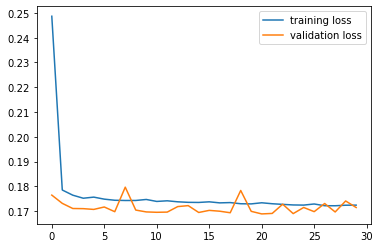

In [167]:
plt.plot(history.history['loss'],label = "training loss")
plt.plot(history.history['val_loss'], label = "validation loss")
plt.legend()
plt.show()

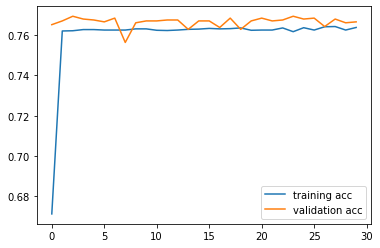

In [168]:
plt.plot(history.history['Acc'],label = "training acc")
plt.plot(history.history['val_Acc'], label = "validation acc")
plt.legend()
plt.show()

### pytorch

In [169]:
# load libraries
import torch
from torch.utils.data import DataLoader
# set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [170]:
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

In [171]:
# convert train data to list with labels
train_data = []
for i in range(len(train)):
    train_data.append((int(train['helpfulness_cat'][i]), train['imdb_user_review'][i]))

In [172]:
# check null values in train_data
null_count = 0
for i in range(len(train_data)):
    if train_data[i][0] == 'nan':
        null_count += 1
print("Null values in train_data:", null_count)


Null values in train_data: 0


In [173]:
# convert train_data to iterator
train_data_iter = iter(train_data)

In [174]:
# tokenization
tokenizer = get_tokenizer('basic_english')
# apply the tokenizer
# --+ custom function
def yield_tokens(data_iter):
    for _, text in data_iter:
        yield tokenizer(text)
# --+ deploy the tokenizer to get the vocabulary
vocab = build_vocab_from_iterator(yield_tokens(train_data_iter), specials=["<unk>"])
vocab.set_default_index(vocab["<unk>"])

In [175]:
# tokenize Yelp reviews 
text_pipeline = lambda x: vocab(tokenizer(x))
# encode review labels
label_pipeline = lambda x: int(x)

In [176]:
train_data_iter = iter(train_data)

In [177]:
# custom function
def collate_batch(batch):
    label_list, text_list, offsets = [], [], [0]
    for (_label, _text) in batch:
         label_list.append(label_pipeline(_label))
         processed_text = torch.tensor(text_pipeline(_text), dtype=torch.int64)
         text_list.append(processed_text)
         offsets.append(processed_text.size(0))
    label_list = torch.tensor(label_list, dtype=torch.int64)
    offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)
    text_list = torch.cat(text_list)
    return label_list.to(device), text_list.to(device), offsets.to(device)
# deploy the function
dataloader = DataLoader(train_data_iter, batch_size=8, shuffle=False, collate_fn=collate_batch)

In [178]:
train_data_iter = iter(train_data)

In [179]:
# %%
# model creation

# load libraries
from torch import nn
# the class associated with the module
class TextClassificationModel(nn.Module):

    def __init__(self, vocab_size, embed_dim, num_class):
        super(TextClassificationModel, self).__init__()
        self.embedding = nn.EmbeddingBag(vocab_size, embed_dim, sparse=True)
        self.fc = nn.Linear(embed_dim, num_class)
        self.init_weights()

    def init_weights(self):
        initrange = 0.5
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.fc.weight.data.uniform_(-initrange, initrange)
        self.fc.bias.data.zero_()

    def forward(self, text, offsets):
        embedded = self.embedding(text, offsets)
        return self.fc(embedded)

In [180]:
# %%
# model set up
train_data_iter = iter(train_data)
# examples
# classes
num_class = len(set([label for (label, text) in train_data_iter]))
# vocabulary size
vocab_size = len(vocab)
# ebedding bag size
emsize = 64
# model instantiation
model = TextClassificationModel(vocab_size, emsize, num_class).to(device)

In [137]:
train_data_iter = iter(train_data)

In [182]:
# load library 
import time
# custom function for training 
def train(dataloader):
    model.train()
    total_acc, total_count = 0, 0
    log_interval = 500
    start_time = time.time()

    for idx, (label, text, offsets) in enumerate(dataloader):
        optimizer.zero_grad()
        predicted_label = model(text, offsets)
        loss = criterion(predicted_label, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
        optimizer.step()
        total_acc += (predicted_label.argmax(1) == label).sum().item()
        total_count += label.size(0)
        if idx % log_interval == 0 and idx > 0:
            elapsed = time.time() - start_time
            print('| epoch {:3d} | {:5d}/{:5d} batches '
                  '| accuracy {:8.3f}'.format(epoch, idx, len(dataloader),
                                              total_acc/total_count))
            total_acc, total_count = 0, 0
            start_time = time.time()

In [183]:
# custom function for evaluation
def evaluate(dataloader):
    model.eval()
    total_acc, total_count = 0, 0

    with torch.no_grad():
        for idx, (label, text, offsets) in enumerate(dataloader):
            predicted_label = model(text, offsets)
            loss = criterion(predicted_label, label)
            total_acc += (predicted_label.argmax(1) == label).sum().item()
            total_count += label.size(0)
    return total_acc/total_count

In [184]:
train_data_iter = iter(train_data)

In [185]:
# load libraries 
from torch.utils.data.dataset import random_split
from torchtext.data.functional import to_map_style_dataset
# hyperparameters for the search
# --+ epoch
EPOCHS = 10 
# --+ learning rate
LR = 5  
# --+ batch size for training
BATCH_SIZE = 64 
# optimization
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.1)
total_accu = None
# data handling
train_dataset = to_map_style_dataset(train_data_iter)
#test_dataset = to_map_style_dataset(test_iter)
num_train = int(len(train_dataset) * 0.95)
split_train_, split_valid_ = \
    random_split(train_dataset, [num_train, len(train_dataset) - num_train])

train_dataloader = DataLoader(split_train_, batch_size=BATCH_SIZE,
                              shuffle=True, collate_fn=collate_batch)
valid_dataloader = DataLoader(split_valid_, batch_size=BATCH_SIZE,
                              shuffle=True, collate_fn=collate_batch)
#test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE,
                             #shuffle=True, collate_fn=collate_batch)

In [186]:
# check the train_dataloader
for batch in train_dataloader:
    print(batch)
    break

(tensor([1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1,
        0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
        0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1]), tensor([  95,    6,   33,  ..., 1047,  152,    1]), tensor([    0,   176,   341,   355,   505,   550,   652,   819,  2021,  2685,
         2801,  3010,  3730,  3859,  4011,  4208,  4322,  4449,  4606,  4634,
         4990,  5317,  5911,  5936,  6703,  6815,  6887,  7031,  7459,  7711,
         7918,  8073,  8169,  8206,  8309,  8433,  8607,  8751,  8955,  9008,
         9105,  9241,  9382,  9549,  9561,  9577, 10450, 10863, 11005, 11034,
        11205, 11399, 11972, 12010, 12176, 12805, 12920, 12946, 13013, 13065,
        13109, 13231, 13382, 13627]))


In [187]:
# logging
for epoch in range(1, EPOCHS + 1):
    epoch_start_time = time.time()
    train(train_dataloader)
    accu_val = evaluate(valid_dataloader)
    if total_accu is not None and total_accu > accu_val:
      scheduler.step()
    else:
       total_accu = accu_val
    print('-' * 59)
    print('| end of epoch {:3d} | time: {:5.2f}s | '
          'valid accuracy {:8.3f} '.format(epoch,
                                           time.time() - epoch_start_time,
                                           accu_val))
    print('-' * 59)


-----------------------------------------------------------
| end of epoch   1 | time:  2.34s | valid accuracy    0.768 
-----------------------------------------------------------
-----------------------------------------------------------
| end of epoch   2 | time:  2.29s | valid accuracy    0.768 
-----------------------------------------------------------
-----------------------------------------------------------
| end of epoch   3 | time:  2.33s | valid accuracy    0.755 
-----------------------------------------------------------
-----------------------------------------------------------
| end of epoch   4 | time:  2.31s | valid accuracy    0.770 
-----------------------------------------------------------
-----------------------------------------------------------
| end of epoch   5 | time:  2.37s | valid accuracy    0.764 
-----------------------------------------------------------
-----------------------------------------------------------
| end of epoch   6 | time:  2.39s |

In [199]:
# test on random unseen review

# labels
review_label = {1: "helpful",
                0: "unhelpful"}

def predict(text, text_pipeline):
    with torch.no_grad():
        text = torch.tensor(text_pipeline(text))
        output = model(text, torch.tensor([0]))
        return output.argmax(1).item() + 1

ex_text_str = "yes"

model = model.to("cpu")

print("This is a %s movie review" %review_label[predict(ex_text_str, text_pipeline)])

This is a helpful movie review
